In this lab we'll follow the next steps:
1. Downnload data from yesterday lecture
2. Exploratory Data Analysis (EDA)
3. Forecasting models - Prophet

In [1]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

     |████████████████████████████████| 6.3MB 14.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=dbedbdfe392094067dba3365f6e989710e0b259dc105fb7171659810425c120b
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 1. Download data 

Definition of an analysis starting and ending period

In [3]:
start = pd.to_datetime('2017-01-01')
end = date.today()
#custom_end = pd.to_datetime('2021-05-24')

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [4]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [5]:
forex_df = pd.DataFrame()

for ticker in tickers_to_download:
  forex_df = pd.concat([forex_df, yf.download(ticker, start, end)['Close']], axis=1)
  forex_df.rename(columns={'Close': ticker.lower().split('=', 1)[0] + '_close'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
forex_df.dropna(inplace=True)

In [6]:
forex_df

eurusd_close  gbpusd_close  ...  usdcad_close  audusd_close
2017-01-02      1.052698      1.234903  ...       1.34340      0.720981
2017-01-03      1.046003      1.228199  ...       1.34414      0.719683
2017-01-04      1.041992      1.224560  ...       1.34218      0.722993
2017-01-05      1.050089      1.232681  ...       1.32990      0.728704
2017-01-06      1.060592      1.242545  ...       1.32294      0.733837
...                  ...           ...  ...           ...           ...
2021-05-20      1.217285      1.410616  ...       1.21323      0.772030
2021-05-21      1.222539      1.418560  ...       1.20625      0.777000
2021-05-24      1.218324      1.414287  ...       1.20670      0.773000
2021-05-25      1.221464      1.415609  ...       1.20498      0.775080
2021-05-26      1.225640      1.415288  ...       1.20502      0.778574

[1126 rows x 7 columns]

Scaling the Prices by Percantage Change, in order to remove differences between Prices, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate.

In [7]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [8]:
# New Dataframe cleaned
forex_rate_df_clean

eurusd_close  gbpusd_close  ...  usdcad_close  audusd_close
2017-01-03     -0.006360     -0.005429  ...      0.000551     -0.001799
2017-01-04     -0.003835     -0.002963  ...     -0.001458      0.004598
2017-01-05      0.007771      0.006632  ...     -0.009149      0.007899
2017-01-06      0.010001      0.008002  ...     -0.005234      0.007045
2017-01-09     -0.006983     -0.013242  ...      0.000937     -0.003583
...                  ...           ...  ...           ...           ...
2021-05-20     -0.004184     -0.005769  ...      0.004937     -0.008945
2021-05-21      0.004316      0.005632  ...     -0.005753      0.006438
2021-05-24     -0.003448     -0.003012  ...      0.000373     -0.005148
2021-05-25      0.002577      0.000934  ...     -0.001425      0.002691
2021-05-26      0.003419     -0.000227  ...      0.000033      0.004507

[1125 rows x 7 columns]

Aggregated Returns plot 

In [9]:
fig = px.line(forex_rate_df_clean, 
              x=forex_rate_df_clean.index,
              y='eurusd_close',
              template="plotly_white",
              title='All currencies Returns for the Forex dataframe')

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this 
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line 

# Show plot 
fig.show()

# 2. Exploratory Data Analysis (EDA)

### Standard Deviation of the different rates' returns.

In [10]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns, 
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

Correlation analysis between numerical variables. 

In [11]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000, 
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

### Pearson Correlation - MIC

Text(0.5, 1.0, 'Correlation Heatmap')

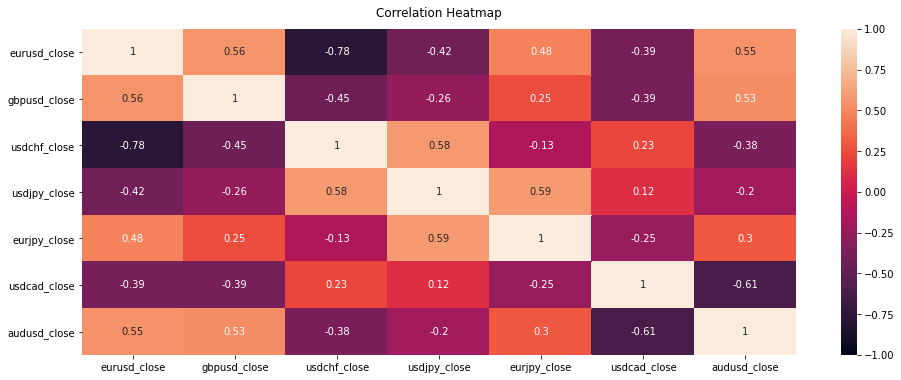

In [12]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### Monte Carlo Simulation

In [13]:
forex_rate_df_clean.head()

eurusd_close  gbpusd_close  ...  usdcad_close  audusd_close
2017-01-03 00:00:00     -0.006360     -0.005429  ...      0.000551     -0.001799
2017-01-04 00:00:00     -0.003835     -0.002963  ...     -0.001458      0.004598
2017-01-05 00:00:00      0.007771      0.006632  ...     -0.009149      0.007899
2017-01-06 00:00:00      0.010001      0.008002  ...     -0.005234      0.007045
2017-01-09 00:00:00     -0.006983     -0.013242  ...      0.000937     -0.003583

[5 rows x 7 columns]

In [14]:
returns = forex_rate_df_clean['eurusd_close'].dropna()
# Monte Carlo sul prezzo ma basato sulla possibilità di avere uno shock sui ritorni, con distribuzione Normale in t ad un prezzo P 

In [16]:
#variazione da 30 a 300
days = 300  # time horizon
dt = 1/float(days) # drift (average growth rate)

#mu: drift sui ritorni, perchè 

In [17]:
import numpy
mu = returns.mean()
#vedi mercuri (varianza della media campionaria)
sigma = returns.std() / numpy.sqrt(dt)

In [34]:
def random_walk(startprice):
    price = numpy.zeros(days)
    shock = numpy.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt)) 
        price[i] = max(0,0.002+ price[i-1] + shock[i] )
    return price

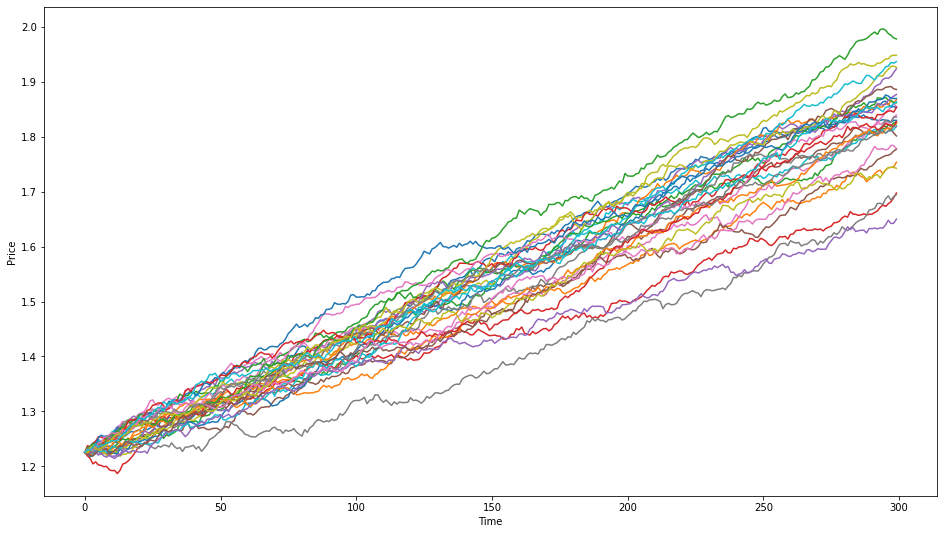

In [39]:
plt.figure(figsize=(16, 9))  
for run in range(30):
    plt.plot(random_walk(forex_df['eurusd_close'][-1]))
plt.xlabel("Time")
plt.ylabel("Price");

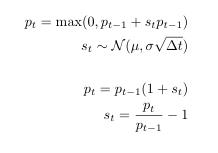

Final rate related to EUR/USD is spread out between 1 to 1.5. 

Now let’s run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final rate, and obtain quantile measures for the Value at Risk estimation.

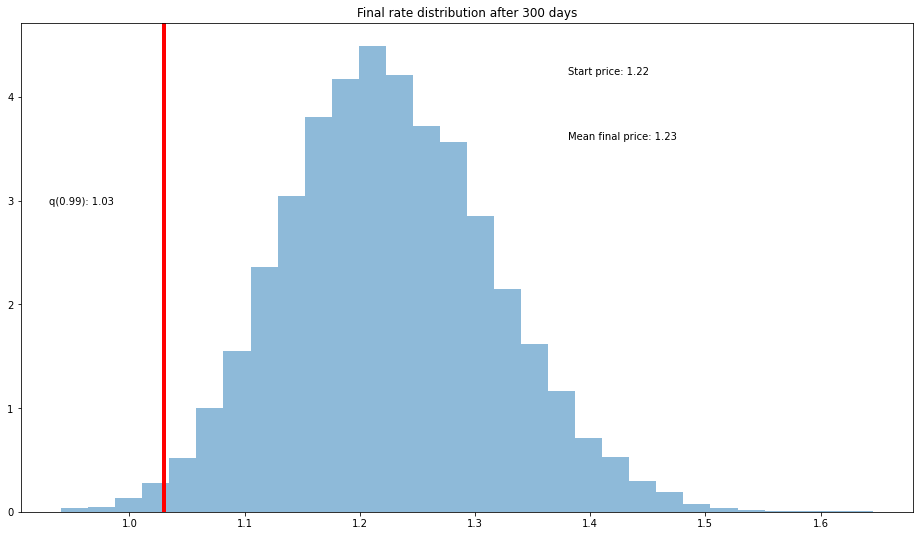

In [ ]:
runs = 10000
simulations = numpy.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(forex_df['eurusd_close'][-1])[days-1]
q = numpy.percentile(simulations, 1)

plt.figure(figsize=(16, 9))
plt.hist(simulations, density=True, bins=30, histtype="stepfilled", alpha=0.5)
plt.figtext(0.6, 0.8, f"Start price: {forex_df['eurusd_close'][-1]:.3}")
plt.figtext(0.6, 0.7, f"Mean final price: {simulations.mean():.3}")
plt.figtext(0.15, 0.6, f"q(0.99): {q:.3}")
plt.axvline(x=q, linewidth=4, color="red")
plt.title(f"Final rate distribution after {days} days");

# 3. Forecasting Method - Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [ ]:
forex_df

eurusd_close  gbpusd_close  ...  usdcad_close  audusd_close
2017-01-02      1.052698      1.234903  ...       1.34340      0.720981
2017-01-03      1.046003      1.228199  ...       1.34414      0.719683
2017-01-04      1.041992      1.224560  ...       1.34218      0.722993
2017-01-05      1.050089      1.232681  ...       1.32990      0.728704
2017-01-06      1.060592      1.242545  ...       1.32294      0.733837
...                  ...           ...  ...           ...           ...
2021-05-19      1.222400      1.418802  ...       1.20727      0.778998
2021-05-20      1.217285      1.410616  ...       1.21323      0.772030
2021-05-21      1.222539      1.418560  ...       1.20625      0.777000
2021-05-24      1.218324      1.414287  ...       1.20670      0.773000
2021-05-25      1.224590      1.415308  ...       1.20469      0.775284

[1124 rows x 7 columns]

In [ ]:
# In order to forecast the series we need to: 1. 
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

eurusd_close  gbpusd_close  ...         ds         y
2021-05-19 00:00:00      1.222400      1.418802  ... 2021-05-19  1.222400
2021-05-20 00:00:00      1.217285      1.410616  ... 2021-05-20  1.217285
2021-05-21 00:00:00      1.222539      1.418560  ... 2021-05-21  1.222539
2021-05-24 00:00:00      1.218324      1.414287  ... 2021-05-24  1.218324
2021-05-25 00:00:00      1.224590      1.415308  ... 2021-05-25  1.224590

[5 rows x 9 columns]

Create train and test, test used in prophet only for backtesting reason!

In [ ]:
#diamo un train maggiore

In [ ]:
train = forex_df[:-20]
test = forex_df[-20:]

m = Prophet()
m.fit(train[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(20, freq='B') # Explain B
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

In [ ]:
forecast_results

yhat  yhat_lower  yhat_upper
ds                                          
2021-04-28  1.195604    1.184292    1.207550
2021-04-29  1.194984    1.183404    1.206334
2021-04-30  1.194281    1.183078    1.205567
2021-05-03  1.192977    1.182174    1.204947
2021-05-04  1.192809    1.180659    1.204827
2021-05-05  1.192393    1.181098    1.204438
2021-05-06  1.191818    1.180972    1.203396
2021-05-07  1.191253    1.179672    1.203098
2021-05-10  1.190893    1.178960    1.203222
2021-05-11  1.191194    1.178707    1.203057
2021-05-12  1.191311    1.179870    1.203434
2021-05-13  1.191319    1.179397    1.203013
2021-05-14  1.191377    1.180196    1.202253
2021-05-17  1.192998    1.181515    1.204531
2021-05-18  1.193954    1.180789    1.206204
2021-05-19  1.194703    1.182247    1.206698
2021-05-20  1.195311    1.183594    1.206941
2021-05-21  1.195926    1.183720    1.206899
2021-05-24  1.198882    1.186061    1.210685
2021-05-25  1.200155    1.187091    1.212466

In [ ]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [ ]:
final_df_results

eurusd_close      yhat
ds                                
2021-04-28      1.209031  1.195604
2021-04-29      1.213592  1.194984
2021-04-30      1.212709  1.194281
2021-05-03      1.202776  1.192977
2021-05-04      1.206127  1.192809
2021-05-05      1.201504  1.192393
2021-05-06      1.200797  1.191818
2021-05-07      1.206855  1.191253
2021-05-10      1.217108  1.190893
2021-05-11      1.214093  1.191194
2021-05-12      1.214450  1.191311
2021-05-13      1.207851  1.191319
2021-05-14      1.207729  1.191377
2021-05-17      1.215037  1.192998
2021-05-18      1.215687  1.193954
2021-05-19      1.222400  1.194703
2021-05-20      1.217285  1.195311
2021-05-21      1.222539  1.195926
2021-05-24      1.218324  1.198882
2021-05-25      1.224590  1.200155

## Model evaluation and scores

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()